# Near to far field transformation

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/Near2Far_ZonePlate.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/Near2Far_ZonePlate.ipynb), or just follow along with the output below.

This tutorial will show you how to solve for electromagnetic fields far away from your structure using field information stored on a nearby surface.

This technique is called a 'near field to far field transformation' and is very useful for reducing the simulation size needed for structures involving lots of empty space.

As an example, we will simulate a simple zone plate lens with a very thin domain size to get the transmitted fields measured just above the structure.  Then, we'll show how to use the `Near2Far` feature from `tidy3D` to extrapolate to the fields at the focal plane above the lens.

In [1]:
# get the most recent version of tidy3d
# !pip install -q --upgrade tidy3d

# make sure notebook plots inline
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

# import client side tidy3d
import tidy3d as td
import tidy3d_core as tdcore

## Problem Setup
Below is a rough sketch of the setup of a near field to far field transformation.

The transmitted near fields are measured just above the metalens on the blue line, and the near field to far field transformation is then used to project the fields to the focal plane above at the red line.

<img src="img/n2f_diagram.png" width=800>

## Define Simulation Parameters

As always, we first need to define our simulation parameters.  As a reminder, all length units in `tidy3D` are specified in microns.

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 1.0

# numerical aperture
NA = 0.8

# thickness of lens features
thickness_lens = 200 * nm

# space between bottom PML and substrate (-z)
# and the space between lens structure and top pml (+z)
space_below_sub = 1.5 * wavelength

# thickness of substrate (um)
thickness_sub = wavelength / 2

# side length (xy plane) of entire metalens (um)
length_xy = 40 * wavelength

# Lens and substrate refractive index
n_TiO2 = 2.40
n_SiO2 = 1.46

# define material properties
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)

# resolution of simulation (15 or more grids per wavelength is adequate)
grids_per_wavelength = 20

# Number of PML layers to use around edges of simulation, choose thickness of one wavelength to be safe
npml = grids_per_wavelength

## Process Geometry

Next we perform some conversions based on these parameters to define the simulation.

In [3]:
# grid size (um)
dl = wavelength / grids_per_wavelength

# because the wavelength is in microns, use builtin td.C_0 (um/s) to get frequency in Hz
f0 = td.constants.C_0 / wavelength
f0 = 2.0

# Define PML layers, for this application we surround the whole structure in PML to isolate the fields
pml_layers = 3*[td.PMLLayer(num_layers=npml)]

# domain size in z, note, we're just simulating a thin slice: (space -> substrate -> lens thickness -> space)
length_z = space_below_sub + thickness_sub + thickness_lens + space_below_sub

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

## Create Geometry

Now we create the ring metalens programatically

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + thickness_sub / 2.0],
        size=[td.inf, td.inf, thickness_sub]
    ),
    medium=SiO2
)

# create a running list of structures
geometry = [substrate]

# focal length
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# location from center for edge of the n-th inner ring, see https://en.wikipedia.org/wiki/Zone_plate
def edge(n):
    return np.sqrt(n * wavelength * focal_length + n**2 * wavelength**2 / 4)

# loop through the ring indeces until it's too big and add each to geometry list
n = 1
r = edge(n)

while r < 2 * length_xy:
    # progressively wider cylinders, material alternating between air and TiO2 

    cylinder = td.Structure(
        geometry=td.Cylinder(
            center = [0,0,-length_z/2  + space_below_sub + thickness_sub + thickness_lens / 2],
            axis=2,
            radius=r,
            length=thickness_lens),
        medium=TiO2 if n % 2 == 0 else air,
    )
    geometry.append(cylinder)
    n += 1
    r = edge(n)

# reverse geometry list so that inner, smaller rings are added last and therefore override larger rings.
geometry.reverse()

## Create Source

Create a plane wave incident from below the metalens

In [5]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

source = td.PlaneWave(
            center=(0,0,-length_z/2 + space_below_sub / 2),
            size=(td.inf, td.inf, 0),
            source_time=gaussian,
            direction='+',
            polarization='Jx')

# Simulation run time
run_time = 40 / fwidth

## Create Monitor

Create a near field monitor to measure the fields just above the metalens

In [6]:
# place it halfway between top of lens and PML
pos_monitor_z = -length_z/2 + space_below_sub + thickness_sub + thickness_lens + space_below_sub / 2
monitor_near = td.FieldMonitor(
    center=[0., 0., pos_monitor_z],
    size=[length_xy, length_xy, 0],
    freqs=[f0],
)


## Create Simulation

Put everything together and define a simulation object


In [7]:
simulation = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=geometry,
    sources={'planewave': source},
    monitors={'near_field': monitor_near},
    run_time=run_time,
    pml_layers=pml_layers)

## Visualize Geometry

Lets take a look and make sure everything is defined properly


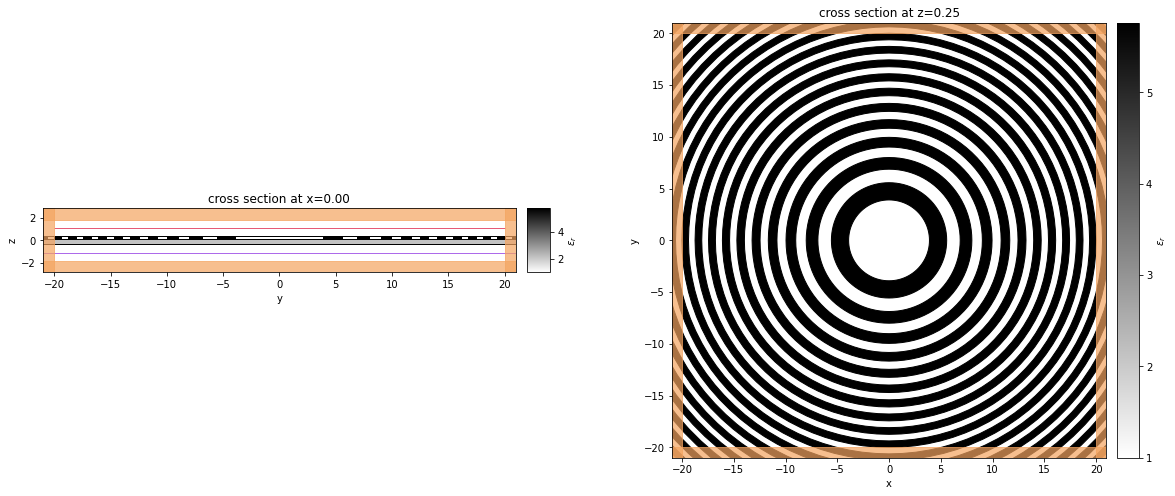

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
simulation.plot_eps(x=0, ax=ax1);
simulation.plot_eps(z=-length_z/2  + space_below_sub + thickness_sub + thickness_lens / 2, ax=ax2);

## Run Simulation

Now we can run the simulation and download the results


In [9]:
# Run simulation
# project = web.new_project(sim.export(), task_name='near2far_docs')
# web.monitor_project(project['taskId'])

In [10]:
# # download and load the results
# print('Downloading results')
# web.download_results(project['taskId'], target_folder='out')
# sim.load_results('out/monitor_data.hdf5')

# # print stats from the logs
# with open("out/tidy3d.log") as f:
#      print(f.read())

In [11]:
solver_data_dict = tdcore.solve(simulation)
sim_data = tdcore.load_solver_results(simulation=simulation, solver_data_dict=solver_data_dict)

## Visualization 

Let's inspect the near field using the Tidy3D builtin field visualization methods.  
For more details see the documentation of [viz_field_2D](https://simulation.cloud/docs/html/generated/tidy3d.Simulation.viz_field_2D.html#tidy3d.Simulation.viz_field_2D).

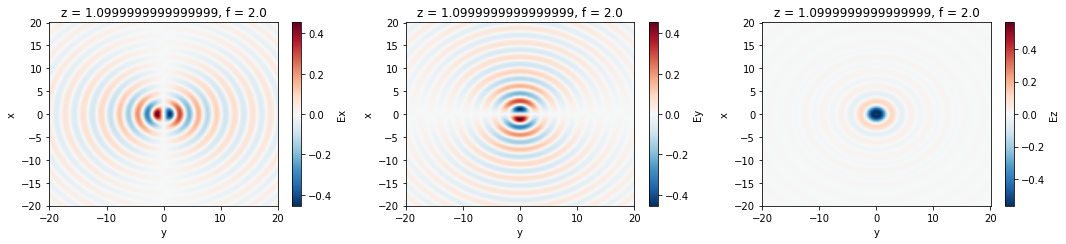

In [12]:
near_field_data = sim_data['near_field']

fig, axes = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))
for ax, direction in zip(axes, 'xyz'):
    near_field_data['E' + direction].real.plot(ax=ax)
plt.show()

## Setting Up Near 2 Far

To set up near to far, we first need to grab the data from the nearfield monitor.

Then, we create a `td.Near2Far` object using the monitor data dictionary as follows.

This object just stores near field data and provides [various methods](https://simulation.cloud/docs/html/generated/tidy3d.Near2Far.html#tidy3d.Near2Far) for looking at various far field quantities.

In [13]:
# from near2far_tidy3d import Near2Far
from tidy3d.plugins import Near2Far
n2f = Near2Far(sim_data.monitor_data['near_field'])

## Getting Far Field Data

With the `Near2Far` object initialized, we just need to call one of it's methods to get a far field quantity.

For this example, we use `Near2Far.get_fields_cartesian(x,y,z)` to get the fields at an `x,y,z` point relative to the monitor center.

Below, we scan through x and y points in a plane located at `z=z0` and record the far fields.

In [14]:
# points to project to
num_far = 10
xs_far = 4 * wavelength * np.linspace(-0.5, 0.5, num_far)
ys_far = 4 * wavelength * np.linspace(-0.5, 0.5, num_far)

# initialize the far field values
E_far = np.zeros((3, num_far, num_far), dtype=complex)
H_far = np.zeros((3, num_far, num_far), dtype=complex)        

from rich.progress import track

# loop through points in the output plane
for i in track(range(num_far), description='Performing Far-field transformation...'):

    x = xs_far[i]
    for j in range(num_far):
        y = ys_far[j]

        # compute and store the outputs from projection function at the focal plane
        E, H = n2f.get_fields_cartesian(x, y, focal_length)
        E_far[:, i, j] = np.squeeze(E)
        H_far[:, i, j] = np.squeeze(H)


Output()

## Plot Results
Now we can plot the near and far fields together

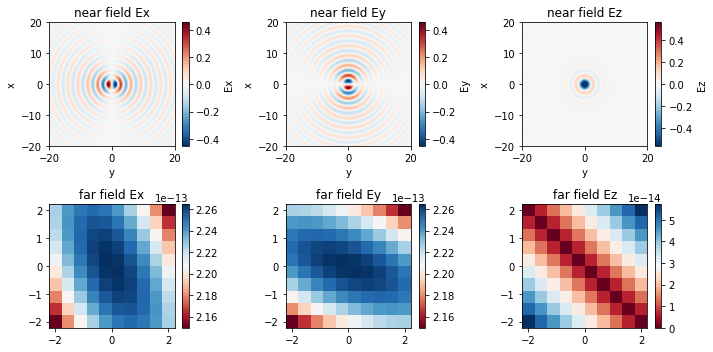

In [15]:
# plot everything
f, (axes_near, axes_far) =  plt.subplots(2, 3, tight_layout=True, figsize=(10, 5))

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

for ax, direction in zip(axes_near, 'xyz'):
    im = near_field_data['E' + direction].real.plot(ax=ax)
    ax.set_title(f'near field E{direction}')

for ax, direction, E in zip(axes_far, 'xyz', E_far):
    im = pmesh(xs_far, ys_far, np.abs(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction}')
    plt.colorbar(im, ax=ax)

plt.show()

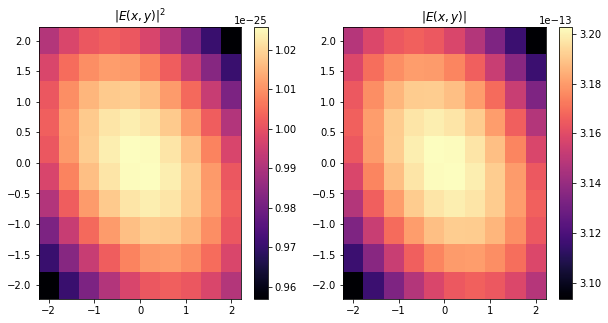

In [16]:
# we can also use the far field data and plot the field intensity to see the focusing effect

intensity_far = np.sum(np.square(np.abs(E_far)), axis=0)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = pmesh(xs_far, ys_far, intensity_far, ax=ax1, cmap='magma')
im2 = pmesh(xs_far, ys_far, np.sqrt(intensity_far), ax=ax2, cmap='magma')

ax1.set_title('$|E(x,y)|^2$')
ax2.set_title('$|E(x,y)|$')

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.show()